In [ ]:
! pip install kaggle

In [73]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import glob

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import svm
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
! mkdir ~/.kaggle

In [8]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download -d miracle9to9/files1

 99% 521M/525M [00:24<00:00, 22.9MB/s]
100% 525M/525M [00:24<00:00, 22.6MB/s]


In [11]:
! unzip /content/files1.zip

Streaming output truncated to the last 5000 lines.
  inflating: Malaria Cells/training_set/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: Malaria Cells/training_set/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: Malaria Cells/training_set/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: Malaria Cells/training_set/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: Malaria Cells/training_set/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: Malaria Cells/training_set/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: Malaria Cells/training_set/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: Malaria Cells/training_set/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: Malaria Cells/training_set/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: Malaria Cells/training_set/Uninfected/C236ThinF_IMG_20151127_102428_cell

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep  9 17:42:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


### Defining the path data directory

In [12]:
data_dir = "/content/Malaria Cells/training_set"
test_dir = "/content/Malaria Cells/testing_set"

### Defining parameters for data preprocessing

In [13]:
batch_size = 512
image_size = (128, 128)
validation_split = 0.2

### Data augmentation

#### Augmentation for train set including normalization

In [14]:
data_augmentation_for_train = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)  # Normalization
])

#### Only normalizing the test set

In [15]:
data_augmentation_for_test = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)  # Normalization
])

### Loading the using the image_dataset_from_directory method

#### Loading the train data

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = validation_split,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="binary"
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


#### Loading the test data

In [17]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="binary"
)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['Parasitized', 'Uninfected']


### showing the count of the train data

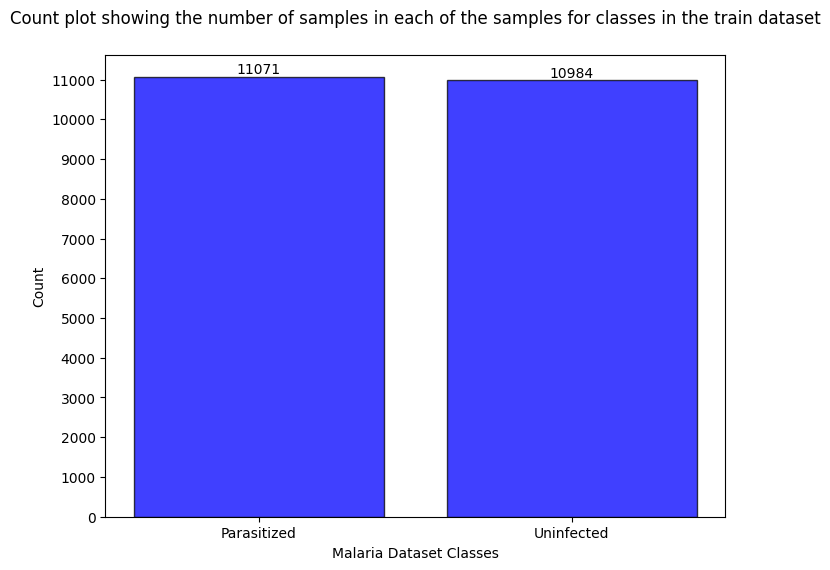

In [ ]:
# Extract labels from train_ds
labels = []
for _, label in train_ds:
    labels.extend(label.numpy().tolist())

# Convert labels to a NumPy array
labels_array = np.array(labels)

# Get unique labels and their counts
unique_labels, label_counts = np.unique(labels_array, return_counts=True)

# Create a count plot using Matplotlib
plt.figure(figsize=(8, 6))
hist, bins, _ = plt.hist(labels_array, bins=np.arange(labels_array.min(), labels_array.max()+2) - 0.5, rwidth=0.8, alpha=0.75, color='b', edgecolor='k')
plt.xticks(unique_labels, class_names)
plt.xlabel("Malaria Dataset Classes")
plt.ylabel("Count")
plt.title("Count plot showing the number of samples in each of the samples for classes in the train dataset", y=1.05)
plt.yticks(np.arange(0, max(plt.gca().get_ylim()), 1000))

# Add total count for each class on top of each bar
for i, count in enumerate(label_counts):
    plt.text(unique_labels[i], count, str(count), ha='center', va='bottom')

plt.show()

### showing samples of the classes of in the malaria dataset

(512, 128, 128, 3)
(512, 1)


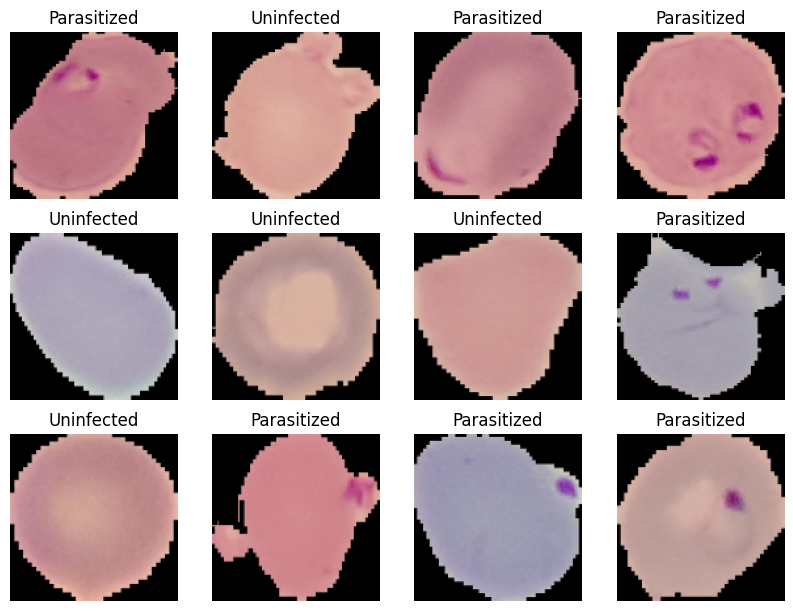

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):

  for i in range(12):
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[int(labels[i][0].numpy())])
      plt.axis("off")
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

### Adding cache

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Adding data augmentation to the train data and normalizing the test data

In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation_for_train(x, training=True), y))
val_ds = val_ds.map(lambda x, y: (data_augmentation_for_test(x, training=True), y))

### Defining a class use pretrained models on the malaria dataset

In [ ]:
class pretrained_models():
    # The class is initialized with the base pretrained model to be used at an instance
    def __init__(self, base_model):
        tf.keras.backend.clear_session()
        self.base_model = base_model(weights = "imagenet",input_shape = (128, 128, 3),include_top = False,)
        self.model = None
        self.history = None
        self.finetune_history = None
        self.model_name = None


    # This method defines the architecture of the pretrained model and compiles it
    def define_model_architecture(self, drop_out, optimizer, loss, metrics):
        # Freeze the base model
        self.base_model.trainable = False

        # Create new model on top of the final layer of the pretrained model
        inputs = tf.keras.Input(shape=(128, 128, 3))
        x = inputs
        x = self.base_model(x, training = False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        # x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.Dropout(drop_out)(x)
        outputs = tf.keras.layers.Dense(1, activation = "sigmoid")(x)

        self.model = tf.keras.Model(inputs, outputs)
        self.model.summary()

        self.model.compile(
            optimizer = optimizer,
            loss = loss,
            metrics = metrics
        )

    # This method fits the pretrained model on the malaria dataset
    def fit_model(self, epochs):
        self.history = self.model.fit(
            train_ds,
            epochs = epochs,
            validation_data = val_ds
        )

    # This model unfreezes the pretrained model to allow all the parameters train and compiles it
    def unfreeze_and_compile_model(self, optimizer, loss, metrics, first_lr, second_lr, third_lr, first_epoch_len, second_epoch_len):

        # Define a step decay learning rate schedule
        def lr_schedule(epoch):
            if epoch < first_epoch_len:
                return first_lr  # Initial learning rate
            elif epoch < second_epoch_len:
                return second_lr  # Lower learning rate for later epochs
            else:
                return third_lr

        # Create the LearningRateScheduler callback
        self.lr_callback = LearningRateScheduler(lr_schedule)

        # Unfreeze the base model and train with all the params
        self.base_model.trainable = True
        self.model.summary()

        self.model.compile(
            optimizer = optimizer,
            loss = loss,
            metrics = metrics
        )


    # Fitting the data on the model with all the parameters trainable leads to fintuning and that is what this method does
    def fine_tune_model(self, epochs):
        self.finetune_history = self.model.fit(
            train_ds,
            epochs = epochs,
            validation_data = val_ds,
            callbacks=[self.lr_callback]
        )


    # This method plots the accuracy, loss, validation accuracy and validation loss for the pretrained model
    def plot_accuracy_and_loss(self, model_name, acc_y_lower_lim, loss_y_upper_limit, cutom_acc_yticks, custom_loss_yticks):

        self.model_name = model_name
        history = self.history
        finetune_history = self.finetune_history

        initial_epochs = history.epoch[-1]

        acc = history.history["accuracy"] + finetune_history.history["accuracy"]
        val_acc = history.history["val_accuracy"] + finetune_history.history["val_accuracy"]
        loss = history.history["loss"] + finetune_history.history["loss"]
        val_loss = history.history["val_loss"] + finetune_history.history["val_loss"]

        # Calculate the y-axis tick positions for increments of 0.2
        acc_y_ticks = np.arange(acc_y_lower_lim, 1.02, 0.02)
        loss_y_ticks = np.arange(0, loss_y_upper_limit + 0.02, 0.02)



        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label="Training Accuracy")
        plt.plot(val_acc, label="Validation Accuracy")

        if cutom_acc_yticks:
            plt.yticks(acc_y_ticks)  # Set custom y-axis ticks

        plt.ylim([acc_y_lower_lim, 1])
        plt.plot([initial_epochs - 0.15,initial_epochs - 0.15],
        plt.ylim(), label="Start Fine Tuning")
        plt.legend(loc="lower right")
        plt.title(f"Training and Validation Accuracy for {model_name}")
        plt.subplot(2, 1, 2)
        plt.plot(loss, label="Training Loss")
        plt.plot(val_loss, label="Validation Loss")

        if custom_loss_yticks:
            plt.yticks(loss_y_ticks)  # Set custom y-axis ticks

        plt.ylim([0, loss_y_upper_limit])
        plt.plot([initial_epochs - 0.15,initial_epochs - 0.15],
        plt.ylim(), label="Start Fine Tuning")
        plt.legend(loc="upper right")
        plt.title(f"Training and Validation Loss for {model_name}")
        plt.xlabel("epoch")
        plt.show()


    # This method plots the classification report and the confusion matrix of predicting the data with the pretrained model.
    def print_model_classification_report(self):
        model = self.model
        print(f"Training accuracy: {self.finetune_history.history['accuracy']}")
        print(f"Validation accuracy: {self.finetune_history.history['val_accuracy']}")
        print("")


        datagen = ImageDataGenerator(rescale=1.0/255.0)

        test_ds = datagen.flow_from_directory(
            test_dir,
            target_size = image_size,
            batch_size = 512,
            class_mode="binary",
            shuffle = False
        )

        true_labels = test_ds.labels
        #print(true_labels)

        y_pred = model.predict(test_ds)
        #print(y_pred)
        y_pred = np.round(y_pred).flatten()

        print(classification_report(true_labels, y_pred, digits=4))

        plt.figure(dpi=200, figsize=(10,15))
        ConfusionMatrixDisplay.from_predictions(true_labels, y_pred, display_labels = class_names)
        plt.title(f"Confusion Matrix for {self.model_name} model")
        plt.show()

In [ ]:
optimizers = tf.keras.optimizers
losses = tf.keras.losses

### Using the Inception V3 model

In [ ]:
# (1) Create an instance of the pretrained_models class for the inceptionV3 model
InceptionV3 = pretrained_models(tf.keras.applications.InceptionV3)

In [ ]:
# (2) Defining the architecture and compiling the inceptionV3 model
InceptionV3.define_model_architecture(0.2, optimizers.Adam(), losses.binary_crossentropy, ["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21804833 (83.18 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 21802784 (83.17 MB)
__________________

In [ ]:
# (3) Fitting the inceptionV3 model on the data
with tf.device('/GPU:0'):
  InceptionV3.fit_model(9)

Epoch 1/9
44/44 [==============================] - 81s 2s/step - loss: 0.4721 - accuracy: 0.7873 - val_loss: 0.3063 - val_accuracy: 0.8701
Epoch 2/9
44/44 [==============================] - 75s 2s/step - loss: 0.3540 - accuracy: 0.8524 - val_loss: 0.2712 - val_accuracy: 0.8902
Epoch 3/9
44/44 [==============================] - 75s 2s/step - loss: 0.3282 - accuracy: 0.8658 - val_loss: 0.2574 - val_accuracy: 0.8942
Epoch 4/9
44/44 [==============================] - 75s 2s/step - loss: 0.3211 - accuracy: 0.8682 - val_loss: 0.2544 - val_accuracy: 0.8982
Epoch 5/9
44/44 [==============================] - 75s 2s/step - loss: 0.3145 - accuracy: 0.8732 - val_loss: 0.2458 - val_accuracy: 0.9060
Epoch 6/9
44/44 [==============================] - 75s 2s/step - loss: 0.3003 - accuracy: 0.8779 - val_loss: 0.2441 - val_accuracy: 0.9046
Epoch 7/9
44/44 [==============================] - 75s 2s/step - loss: 0.2978 - accuracy: 0.8813 - val_loss: 0.2353 - val_accuracy: 0.9095
Epoch 8/9
44/44 [==========

In [ ]:
# (4) Unfreezing and compiling the pretrained model again
InceptionV3.unfreeze_and_compile_model(optimizers.Adam(1e-6), losses.binary_crossentropy, ["accuracy"], 1e-6, 1e-5, 1e-5, 5, 10)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21804833 (83.18 MB)
Trainable params: 21770401 (83.05 MB)
Non-trainable params: 34432 (134.50 KB)
_______________

In [ ]:
# (5) Fine tuning the inceptionV3 model on for the dataset to improve performance
with tf.device('/GPU:0'):
  InceptionV3.fine_tune_model(31)

Epoch 1/31
44/44 [==============================] - 109s 2s/step - loss: 0.2730 - accuracy: 0.8925 - val_loss: 0.2099 - val_accuracy: 0.9232 - lr: 1.0000e-06
Epoch 2/31
44/44 [==============================] - 77s 2s/step - loss: 0.2350 - accuracy: 0.9105 - val_loss: 0.1932 - val_accuracy: 0.9320 - lr: 1.0000e-06
Epoch 3/31
44/44 [==============================] - 76s 2s/step - loss: 0.2224 - accuracy: 0.9185 - val_loss: 0.1836 - val_accuracy: 0.9379 - lr: 1.0000e-06
Epoch 4/31
44/44 [==============================] - 76s 2s/step - loss: 0.2072 - accuracy: 0.9249 - val_loss: 0.1767 - val_accuracy: 0.9401 - lr: 1.0000e-06
Epoch 5/31
44/44 [==============================] - 76s 2s/step - loss: 0.2031 - accuracy: 0.9278 - val_loss: 0.1678 - val_accuracy: 0.9419 - lr: 1.0000e-06
Epoch 6/31
44/44 [==============================] - 76s 2s/step - loss: 0.1806 - accuracy: 0.9355 - val_loss: 0.1394 - val_accuracy: 0.9517 - lr: 1.0000e-05
Epoch 7/31
44/44 [==============================] - 76s 2

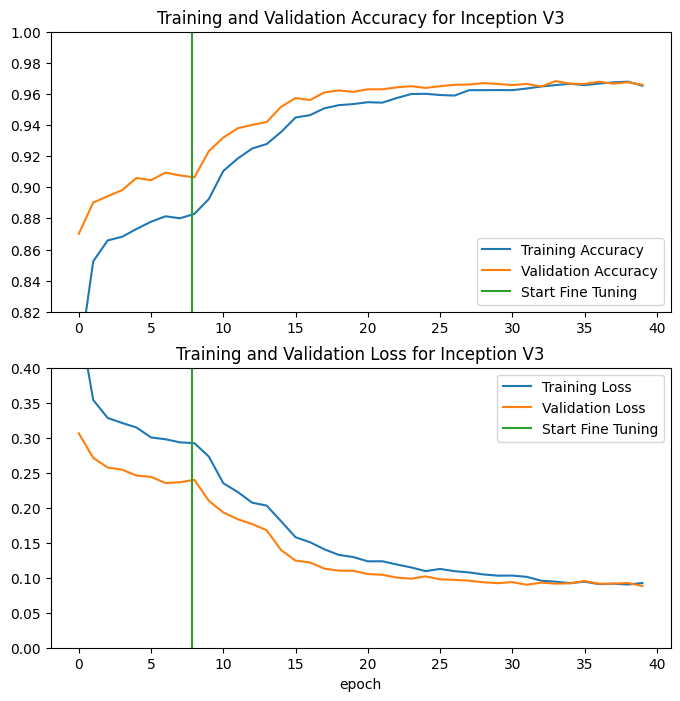

In [ ]:
# (6) plot_accuracy_and_loss
InceptionV3.plot_accuracy_and_loss("Inception V3", 0.82, 0.4, True, False)

Training accuracy: [0.8924570083618164, 0.9104639887809753, 0.918492317199707, 0.9249330759048462, 0.927790641784668, 0.9355468153953552, 0.9448450803756714, 0.9463872909545898, 0.9507869482040405, 0.9527826905250549, 0.9535084366798401, 0.9546877145767212, 0.9544155597686768, 0.9573637843132019, 0.9599491953849792, 0.9600852727890015, 0.9593141674995422, 0.9589513540267944, 0.9623985290527344, 0.9624438881874084, 0.9624892473220825, 0.9624438881874084, 0.9634870886802673, 0.9648024439811707, 0.9657096266746521, 0.9665260314941406, 0.965664267539978, 0.9666621088981628, 0.9674332141876221, 0.9678868055343628, 0.9653013944625854]
Validation accuracy: [0.9232444167137146, 0.9319542646408081, 0.9379423260688782, 0.940119743347168, 0.9419342875480652, 0.951732873916626, 0.9573580026626587, 0.9560878276824951, 0.9609870910644531, 0.9622573256492615, 0.9613500237464905, 0.9629831314086914, 0.9629831314086914, 0.964253306388855, 0.9649791121482849, 0.9638903737068176, 0.9649791121482849, 0.96

<Figure size 2000x3000 with 0 Axes>

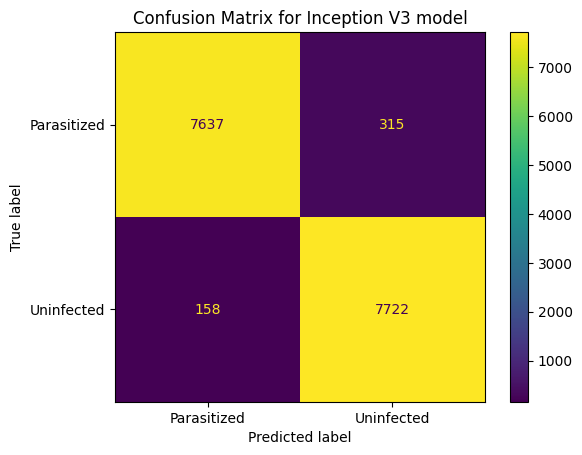

In [ ]:
# (7) Print the classification report and confusion matrix for the model on the test data set
with tf.device('/GPU:0'):
  InceptionV3.print_model_classification_report()

### Using the ResNet101V2 model

In [ ]:
# (1) Create an instance of the pretrained_models class for the ResNet101V2 model
ResNet101V2 = pretrained_models(tf.keras.applications.ResNet101V2)

In [ ]:
# (2) Defining the architecture and compiling the ResNet101V2 model
ResNet101V2.define_model_architecture(0.2, optimizers.Adam(), losses.binary_crossentropy, ["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet101v2 (Functional)    (None, 4, 4, 2048)        42626560  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 42628609 (162.62 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 42626560 (162.61 MB)
________________

In [ ]:
# (3) Fitting the ResNet101V2 model on the data
with tf.device('/GPU:0'):
  ResNet101V2.fit_model(10)

Epoch 1/10
44/44 [==============================] - 83s 2s/step - loss: 0.4287 - accuracy: 0.8073 - val_loss: 0.2859 - val_accuracy: 0.8911
Epoch 2/10
44/44 [==============================] - 76s 2s/step - loss: 0.3089 - accuracy: 0.8738 - val_loss: 0.2437 - val_accuracy: 0.9036
Epoch 3/10
44/44 [==============================] - 76s 2s/step - loss: 0.2795 - accuracy: 0.8881 - val_loss: 0.2372 - val_accuracy: 0.9078
Epoch 4/10
44/44 [==============================] - 76s 2s/step - loss: 0.2680 - accuracy: 0.8950 - val_loss: 0.2193 - val_accuracy: 0.9149
Epoch 5/10
44/44 [==============================] - 76s 2s/step - loss: 0.2557 - accuracy: 0.8995 - val_loss: 0.2133 - val_accuracy: 0.9180
Epoch 6/10
44/44 [==============================] - 76s 2s/step - loss: 0.2526 - accuracy: 0.9024 - val_loss: 0.2049 - val_accuracy: 0.9220
Epoch 7/10
44/44 [==============================] - 76s 2s/step - loss: 0.2516 - accuracy: 0.9030 - val_loss: 0.2157 - val_accuracy: 0.9178
Epoch 8/10
44/44 [==

In [ ]:
# (4) Unfreezing and compiling the pretrained model again
ResNet101V2.unfreeze_and_compile_model(optimizers.Adam(1e-5), losses.binary_crossentropy, ["accuracy"], 1e-6, 1e-6, 1e-5, 5, 20)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet101v2 (Functional)    (None, 4, 4, 2048)        42626560  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 42628609 (162.62 MB)
Trainable params: 42530945 (162.24 MB)
Non-trainable params: 97664 (381.50 KB)
_____________

In [ ]:
# (5) Fine tuning the ResNet101V2 model on for the dataset to improve performance
with tf.device('/GPU:0'):
  ResNet101V2.fine_tune_model(30)

Epoch 1/30
44/44 [==============================] - 135s 2s/step - loss: 0.2249 - accuracy: 0.9160 - val_loss: 0.1730 - val_accuracy: 0.9356 - lr: 1.0000e-06
Epoch 2/30
44/44 [==============================] - 77s 2s/step - loss: 0.1956 - accuracy: 0.9303 - val_loss: 0.1641 - val_accuracy: 0.9423 - lr: 1.0000e-06
Epoch 3/30
44/44 [==============================] - 77s 2s/step - loss: 0.1838 - accuracy: 0.9358 - val_loss: 0.1555 - val_accuracy: 0.9467 - lr: 1.0000e-06
Epoch 4/30
44/44 [==============================] - 77s 2s/step - loss: 0.1742 - accuracy: 0.9388 - val_loss: 0.1511 - val_accuracy: 0.9490 - lr: 1.0000e-06
Epoch 5/30
44/44 [==============================] - 77s 2s/step - loss: 0.1703 - accuracy: 0.9400 - val_loss: 0.1430 - val_accuracy: 0.9508 - lr: 1.0000e-06
Epoch 6/30
44/44 [==============================] - 77s 2s/step - loss: 0.1621 - accuracy: 0.9425 - val_loss: 0.1415 - val_accuracy: 0.9521 - lr: 1.0000e-06
Epoch 7/30
44/44 [==============================] - 77s 2

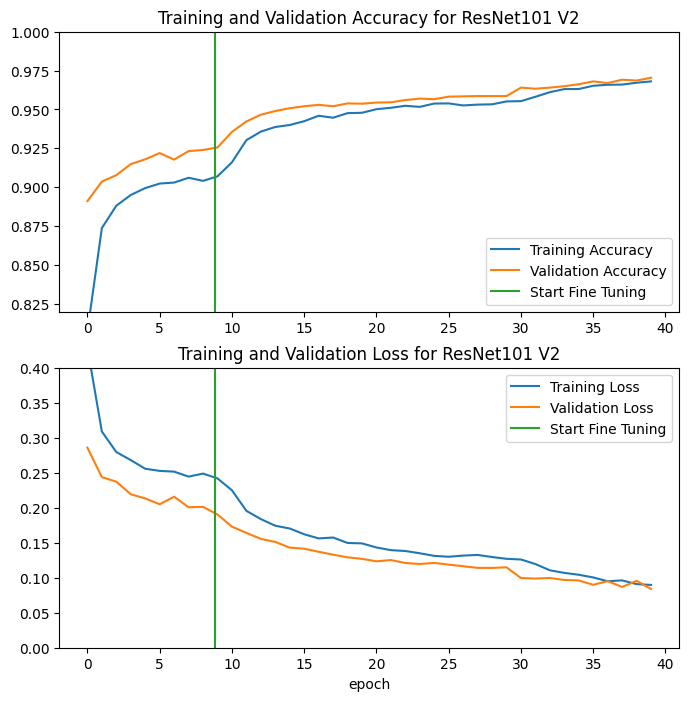

In [ ]:
# (6) plot_accuracy_and_loss
ResNet101V2.plot_accuracy_and_loss("ResNet101 V2", 0.82, 0.4, False, False)

Training accuracy: [0.9160429835319519, 0.9302852749824524, 0.9357735514640808, 0.9387671947479248, 0.940037190914154, 0.9424865245819092, 0.9459790587425232, 0.9447090029716492, 0.9476572871208191, 0.9478840827941895, 0.9501972794532776, 0.951104462146759, 0.9523744583129883, 0.951694130897522, 0.9538258910179138, 0.953916609287262, 0.9526012539863586, 0.9531455636024475, 0.9533270001411438, 0.955186665058136, 0.9553681015968323, 0.9581802487373352, 0.9611284732818604, 0.9631242156028748, 0.9631695747375488, 0.9652560353279114, 0.9658910632133484, 0.9660271406173706, 0.9672064185142517, 0.9680682420730591]
Validation accuracy: [0.9355833530426025, 0.9422972202301025, 0.9466521739959717, 0.9490110874176025, 0.9508256316184998, 0.9520958065986633, 0.9530031085014343, 0.9520958065986633, 0.9539103507995605, 0.9537289142608643, 0.9544547200202942, 0.9546361565589905, 0.9560878276824951, 0.9569951295852661, 0.9566321969032288, 0.9582653045654297, 0.958446741104126, 0.9586281776428223, 0.95

<Figure size 2000x3000 with 0 Axes>

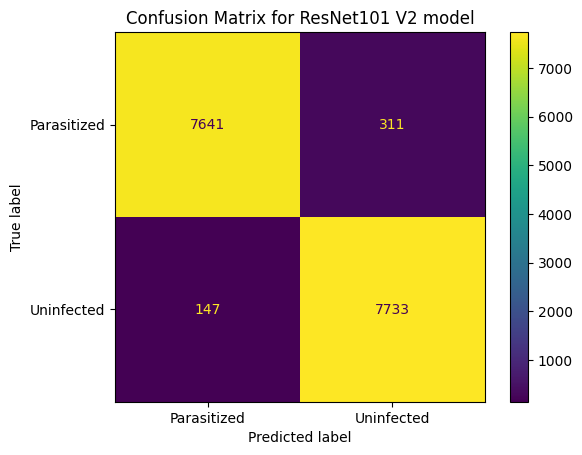

In [ ]:
# (7) Print the classification report and confusion matrix for the model on the test data set
with tf.device('/GPU:0'):
  ResNet101V2.print_model_classification_report()

### Using the VGG16 model

In [ ]:
# (1) Create an instance of the pretrained_models class for the VGG16 model
VGG16 = pretrained_models(tf.keras.applications.VGG16)

In [ ]:
# (2) Defining the architecture and compiling the VGG16 model
VGG16.define_model_architecture(0.2, tf.keras.optimizers.Adam(), losses.binary_crossentropy, ["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 14714688 (56.13 MB)
___________________

In [ ]:
# (3) Fitting the VGG16 model on the data
with tf.device('/GPU:0'):
  VGG16.fit_model(10)

Epoch 1/10
44/44 [==============================] - 81s 2s/step - loss: 0.6920 - accuracy: 0.5639 - val_loss: 0.6298 - val_accuracy: 0.6333
Epoch 2/10
44/44 [==============================] - 76s 2s/step - loss: 0.6323 - accuracy: 0.6495 - val_loss: 0.5916 - val_accuracy: 0.6681
Epoch 3/10
44/44 [==============================] - 76s 2s/step - loss: 0.5934 - accuracy: 0.7087 - val_loss: 0.5579 - val_accuracy: 0.7095
Epoch 4/10
44/44 [==============================] - 76s 2s/step - loss: 0.5613 - accuracy: 0.7415 - val_loss: 0.5284 - val_accuracy: 0.7431
Epoch 5/10
44/44 [==============================] - 76s 2s/step - loss: 0.5359 - accuracy: 0.7623 - val_loss: 0.5178 - val_accuracy: 0.7313
Epoch 6/10
44/44 [==============================] - 76s 2s/step - loss: 0.5198 - accuracy: 0.7757 - val_loss: 0.4988 - val_accuracy: 0.7523
Epoch 7/10
44/44 [==============================] - 76s 2s/step - loss: 0.5035 - accuracy: 0.7824 - val_loss: 0.4745 - val_accuracy: 0.7804
Epoch 8/10
44/44 [==

In [ ]:
# (4) Unfreezing and compiling the VGG16 model again
VGG16.unfreeze_and_compile_model(optimizers.Adam(1e-6), losses.binary_crossentropy, ["accuracy"], 1e-6, 1e-5, 1e-5, 10, 15)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 14715201 (56.13 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [ ]:
# (5) Fine tuning the VGG16 model on for the dataset to improve performance
with tf.device('/GPU:0'):
  VGG16.fine_tune_model(30 )

Epoch 1/30
44/44 [==============================] - 83s 2s/step - loss: 0.3847 - accuracy: 0.8468 - val_loss: 0.2927 - val_accuracy: 0.8819 - lr: 1.0000e-06
Epoch 2/30
44/44 [==============================] - 81s 2s/step - loss: 0.2739 - accuracy: 0.8969 - val_loss: 0.2161 - val_accuracy: 0.9205 - lr: 1.0000e-06
Epoch 3/30
44/44 [==============================] - 81s 2s/step - loss: 0.2256 - accuracy: 0.9184 - val_loss: 0.1813 - val_accuracy: 0.9340 - lr: 1.0000e-06
Epoch 4/30
44/44 [==============================] - 81s 2s/step - loss: 0.1979 - accuracy: 0.9297 - val_loss: 0.1660 - val_accuracy: 0.9416 - lr: 1.0000e-06
Epoch 5/30
44/44 [==============================] - 81s 2s/step - loss: 0.1854 - accuracy: 0.9360 - val_loss: 0.1547 - val_accuracy: 0.9456 - lr: 1.0000e-06
Epoch 6/30
44/44 [==============================] - 81s 2s/step - loss: 0.1771 - accuracy: 0.9397 - val_loss: 0.1544 - val_accuracy: 0.9456 - lr: 1.0000e-06
Epoch 7/30
44/44 [==============================] - 81s 2s

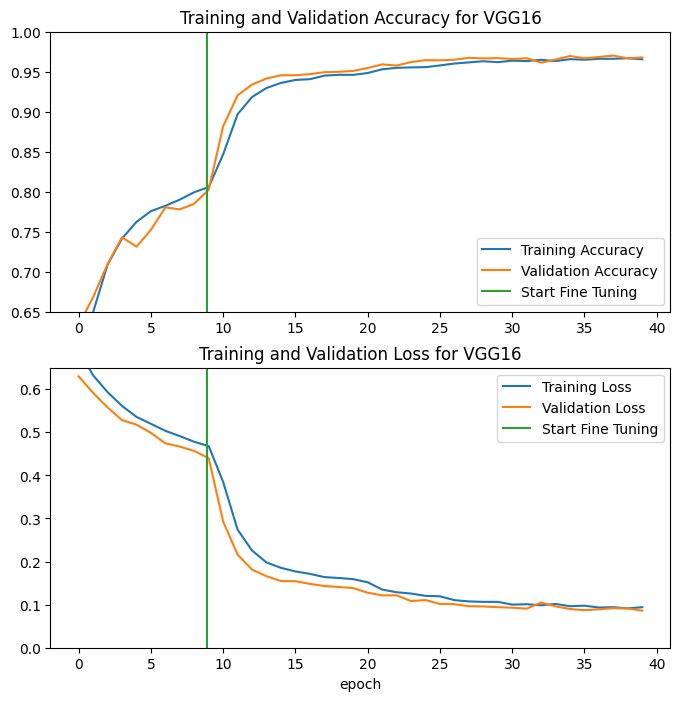

In [ ]:
# (6) plot_accuracy_and_loss
VGG16.plot_accuracy_and_loss("VGG16", 0.65, 0.65, False, False)

Training accuracy: [0.846781849861145, 0.89694744348526, 0.9184015989303589, 0.9296503067016602, 0.9360003471374512, 0.9397196769714355, 0.9406722187995911, 0.9451172351837158, 0.9461604952812195, 0.9460697770118713, 0.9483829736709595, 0.9530548453330994, 0.9548691511154175, 0.9554134607315063, 0.9557309150695801, 0.9578627347946167, 0.9602213501930237, 0.9616727828979492, 0.9630788564682007, 0.9619449377059937, 0.9638046026229858, 0.963260293006897, 0.9649385213851929, 0.963260293006897, 0.9657096266746521, 0.9649838805198669, 0.9661632180213928, 0.9661632180213928, 0.9668435454368591, 0.9655281901359558]
Validation accuracy: [0.8818725943565369, 0.9205225706100464, 0.9339503049850464, 0.9415714144706726, 0.9455634355545044, 0.9455634355545044, 0.9470150470733643, 0.9493739604949951, 0.9499183297157288, 0.951007068157196, 0.9546361565589905, 0.9591725468635559, 0.957720935344696, 0.9620758295059204, 0.9644347429275513, 0.964253306388855, 0.9649791121482849, 0.9673380255699158, 0.9666

<Figure size 2000x3000 with 0 Axes>

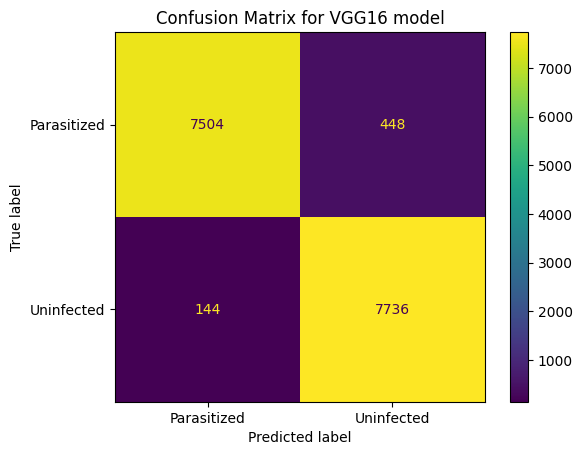

In [ ]:
# (7) Print the classification report and confusion matrix for the model on the test data set
VGG16.print_model_classification_report()

### Using the VGG19 model

In [ ]:
# (1) Create an instance of the pretrained_models class for the VGG19 model
VGG19 = pretrained_models(tf.keras.applications.VGG19)

In [ ]:
# (2) Defining the architecture and compiling the VGG19 model
VGG19.define_model_architecture(0.2, tf.keras.optimizers.Adam(), losses.binary_crossentropy, ["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 20024384 (76.39 MB)
___________________

In [ ]:
# (3) Fitting the VGG19 model on the data
with tf.device('/GPU:0'):
  VGG19.fit_model(10)

Epoch 1/10
44/44 [==============================] - 77s 2s/step - loss: 0.6802 - accuracy: 0.5670 - val_loss: 0.6274 - val_accuracy: 0.7768
Epoch 2/10
44/44 [==============================] - 76s 2s/step - loss: 0.6304 - accuracy: 0.6583 - val_loss: 0.5924 - val_accuracy: 0.7416
Epoch 3/10
44/44 [==============================] - 76s 2s/step - loss: 0.6001 - accuracy: 0.7015 - val_loss: 0.5615 - val_accuracy: 0.7944
Epoch 4/10
44/44 [==============================] - 76s 2s/step - loss: 0.5777 - accuracy: 0.7271 - val_loss: 0.5418 - val_accuracy: 0.7966
Epoch 5/10
44/44 [==============================] - 76s 2s/step - loss: 0.5580 - accuracy: 0.7423 - val_loss: 0.5291 - val_accuracy: 0.7774
Epoch 6/10
44/44 [==============================] - 76s 2s/step - loss: 0.5434 - accuracy: 0.7554 - val_loss: 0.5103 - val_accuracy: 0.8024
Epoch 7/10
44/44 [==============================] - 76s 2s/step - loss: 0.5284 - accuracy: 0.7648 - val_loss: 0.5002 - val_accuracy: 0.7960
Epoch 8/10
44/44 [==

In [ ]:
# (4) Unfreezing and compiling the VGG19 model again
VGG19.unfreeze_and_compile_model(optimizers.Adam(1e-5), losses.binary_crossentropy, ["accuracy"], 1e-6, 1e-5, 1e-5, 10, 20)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [ ]:
# (5) Fine tuning the VGG19 model on for the dataset to improve performance
with tf.device('/GPU:0'):
  VGG19.fine_tune_model(30)

Epoch 1/30
44/44 [==============================] - 87s 2s/step - loss: 0.3961 - accuracy: 0.8395 - val_loss: 0.2997 - val_accuracy: 0.8728 - lr: 1.0000e-06
Epoch 2/30
44/44 [==============================] - 83s 2s/step - loss: 0.2573 - accuracy: 0.9067 - val_loss: 0.2093 - val_accuracy: 0.9236 - lr: 1.0000e-06
Epoch 3/30
44/44 [==============================] - 83s 2s/step - loss: 0.2042 - accuracy: 0.9288 - val_loss: 0.1879 - val_accuracy: 0.9314 - lr: 1.0000e-06
Epoch 4/30
44/44 [==============================] - 83s 2s/step - loss: 0.1851 - accuracy: 0.9377 - val_loss: 0.1730 - val_accuracy: 0.9381 - lr: 1.0000e-06
Epoch 5/30
44/44 [==============================] - 83s 2s/step - loss: 0.1743 - accuracy: 0.9434 - val_loss: 0.1618 - val_accuracy: 0.9434 - lr: 1.0000e-06
Epoch 6/30
44/44 [==============================] - 83s 2s/step - loss: 0.1702 - accuracy: 0.9436 - val_loss: 0.1574 - val_accuracy: 0.9448 - lr: 1.0000e-06
Epoch 7/30
44/44 [==============================] - 83s 2s

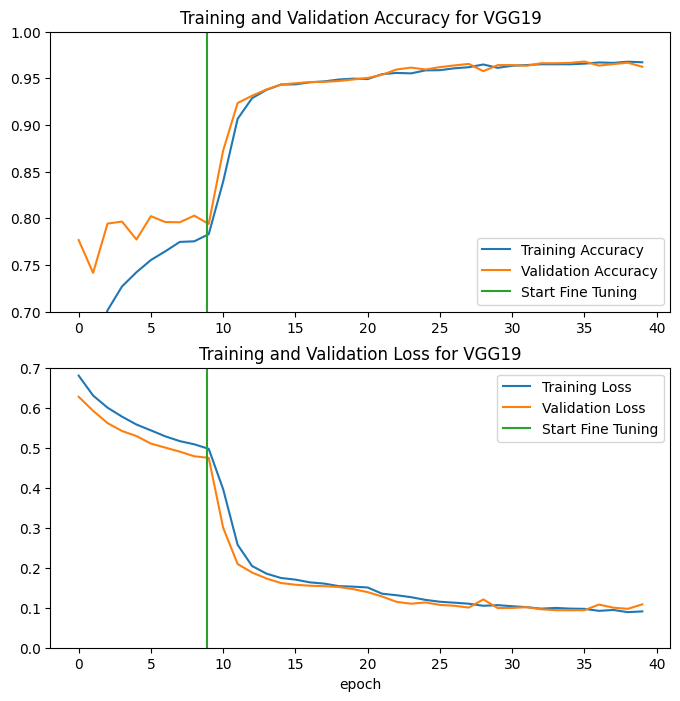

In [ ]:
# (6) plot_accuracy_and_loss
VGG19.plot_accuracy_and_loss("VGG19", 0.7, 0.7, False, False)

Training accuracy: [0.8395246267318726, 0.9066539406776428, 0.9288338422775269, 0.9377239346504211, 0.9433936476707458, 0.9436204433441162, 0.9457976222038269, 0.9467954635620117, 0.9487912058830261, 0.9497437477111816, 0.9492901563644409, 0.954551637172699, 0.9558669924736023, 0.9553681015968323, 0.9585884809494019, 0.9588152766227722, 0.9608110189437866, 0.9619902968406677, 0.9648931622505188, 0.9613099098205566, 0.9635324478149414, 0.9643035531044006, 0.9651199579238892, 0.9651199579238892, 0.9651199579238892, 0.9658003449440002, 0.9670703411102295, 0.9666167497634888, 0.9678868055343628, 0.9672517776489258]
Validation accuracy: [0.8727998733520508, 0.923607349395752, 0.9314098954200745, 0.9381237626075745, 0.9433859586715698, 0.9448375701904297, 0.946107804775238, 0.9462892413139343, 0.9471965432167053, 0.9488295912742615, 0.9504626989364624, 0.9539103507995605, 0.9595354795455933, 0.9615314602851868, 0.9595354795455933, 0.9620758295059204, 0.9638903737068176, 0.9655234813690186, 0

<Figure size 2000x3000 with 0 Axes>

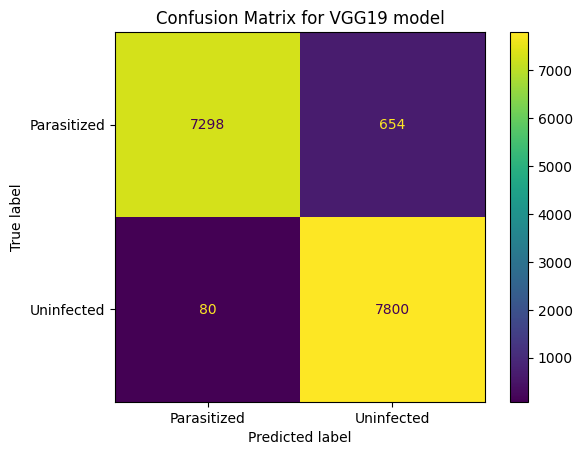

In [ ]:
# (7) Print the classification report and confusion matrix for the model on the test data set
with tf.device('/GPU:0'):
  VGG19.print_model_classification_report()

### Using the MobileNet model

In [ ]:
# (1) Create an instance of the pretrained_models class for the MobileNet model
MobileNetV2 = pretrained_models(tf.keras.applications.MobileNetV2)

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# (2) Defining the architecture and compiling the VGG19 model
MobileNetV2.define_model_architecture(0.2, tf.keras.optimizers.Adam(), losses.binary_crossentropy, ["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 

In [ ]:
# (3) Fitting the VGG19 model on the data
with tf.device('/GPU:0'):
  MobileNetV2.fit_model(10)

Epoch 1/10
44/44 [==============================] - 79s 2s/step - loss: 0.6040 - accuracy: 0.6779 - val_loss: 0.3443 - val_accuracy: 0.8608
Epoch 2/10
44/44 [==============================] - 75s 2s/step - loss: 0.4038 - accuracy: 0.8208 - val_loss: 0.3052 - val_accuracy: 0.8694
Epoch 3/10
44/44 [==============================] - 76s 2s/step - loss: 0.3593 - accuracy: 0.8429 - val_loss: 0.3034 - val_accuracy: 0.8617
Epoch 4/10
44/44 [==============================] - 75s 2s/step - loss: 0.3368 - accuracy: 0.8567 - val_loss: 0.3340 - val_accuracy: 0.8472
Epoch 5/10
44/44 [==============================] - 76s 2s/step - loss: 0.3218 - accuracy: 0.8664 - val_loss: 0.2885 - val_accuracy: 0.8699
Epoch 6/10
44/44 [==============================] - 76s 2s/step - loss: 0.3088 - accuracy: 0.8740 - val_loss: 0.2781 - val_accuracy: 0.8752
Epoch 7/10
44/44 [==============================] - 76s 2s/step - loss: 0.3035 - accuracy: 0.8763 - val_loss: 0.2944 - val_accuracy: 0.8661
Epoch 8/10
44/44 [==

In [ ]:
# (4) Unfreezing and compiling the VGG19 model again
MobileNetV2.unfreeze_and_compile_model(optimizers.Adam(1e-5), losses.binary_crossentropy, ["accuracy"], 1e-5, 1e-5, 1e-5, 8, 20)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 2225153 (8.

In [ ]:
# (5) Fine tuning the VGG19 model on for the dataset to improve performance
with tf.device('/GPU:0'):
  MobileNetV2.fine_tune_model(17)

Epoch 1/25
44/44 [==============================] - 106s 2s/step - loss: 0.2719 - accuracy: 0.8912 - val_loss: 0.2454 - val_accuracy: 0.8938 - lr: 1.0000e-06
Epoch 2/25
44/44 [==============================] - 78s 2s/step - loss: 0.2479 - accuracy: 0.9060 - val_loss: 0.2303 - val_accuracy: 0.9015 - lr: 1.0000e-06
Epoch 3/25
44/44 [==============================] - 77s 2s/step - loss: 0.2309 - accuracy: 0.9138 - val_loss: 0.2117 - val_accuracy: 0.9140 - lr: 1.0000e-06
Epoch 4/25
44/44 [==============================] - 77s 2s/step - loss: 0.2173 - accuracy: 0.9184 - val_loss: 0.2108 - val_accuracy: 0.9138 - lr: 1.0000e-06
Epoch 5/25
44/44 [==============================] - 77s 2s/step - loss: 0.2079 - accuracy: 0.9242 - val_loss: 0.1987 - val_accuracy: 0.9242 - lr: 1.0000e-06
Epoch 6/25
44/44 [==============================] - 78s 2s/step - loss: 0.2042 - accuracy: 0.9256 - val_loss: 0.1948 - val_accuracy: 0.9256 - lr: 1.0000e-06
Epoch 7/25
44/44 [==============================] - 77s 2

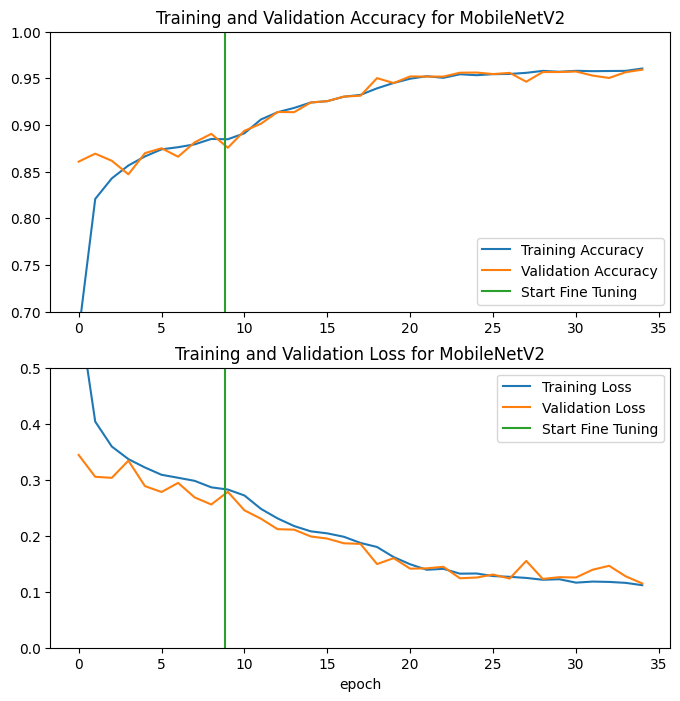

In [ ]:
# (6) plot_accuracy_and_loss
MobileNetV2.plot_accuracy_and_loss("MobileNetV2", 0.7, 0.5, False, False)

Training accuracy: [0.8911870121955872, 0.9060189723968506, 0.9137751460075378, 0.9183562397956848, 0.9241620302200317, 0.9256134629249573, 0.9303759932518005, 0.9323263764381409, 0.939356803894043, 0.9450718760490417, 0.9496530294418335, 0.9523290991783142, 0.9506055116653442, 0.9544155597686768, 0.9534177184104919, 0.954551637172699, 0.9547330737113953, 0.9559577107429504, 0.958044171333313, 0.9570916891098022, 0.9581348896026611, 0.9577266573905945, 0.9579080939292908, 0.958044171333313, 0.9605842232704163]
Validation accuracy: [0.8938486576080322, 0.9014697670936584, 0.9139901995658875, 0.9138087630271912, 0.9241517186164856, 0.9256033301353455, 0.9305026531219482, 0.9314098954200745, 0.9502812623977661, 0.9450190663337708, 0.9520958065986633, 0.951914370059967, 0.951914370059967, 0.9560878276824951, 0.9562692642211914, 0.9546361565589905, 0.9559063911437988, 0.9464706778526306, 0.956813633441925, 0.956813633441925, 0.9573580026626587, 0.9530031085014343, 0.9504626989364624, 0.9566

<Figure size 2000x3000 with 0 Axes>

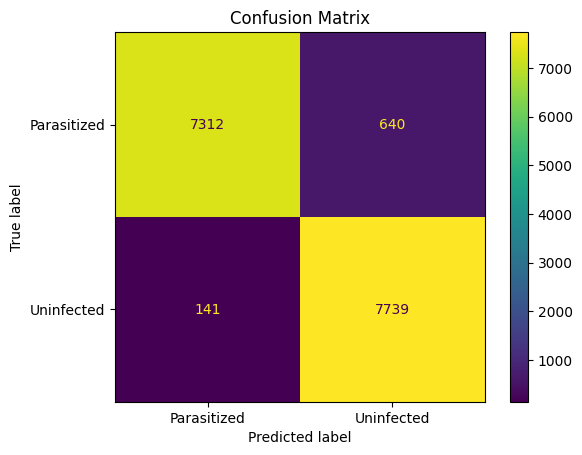

In [ ]:
# (7) Print the classification report and confusion matrix for the model on the test data set
MobileNetV2.print_model_classification_report()

### Using Efficient Net

In [ ]:
# (1) Create an instance of the pretrained_models class for the VGG19 model
EfficientNetB7 = pretrained_models(tf.keras.applications.EfficientNetB3)

In [ ]:
# (2) Defining the architecture and compiling the VGG19 model
EfficientNetB7.define_model_architecture(0.2, tf.keras.optimizers.Adam(), losses.binary_crossentropy, ["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb3 (Functional  (None, 4, 4, 1536)        10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 10785072 (41.14 MB)
Trainable params: 1537 (6.0

In [ ]:
# (3) Fitting the VGG19 model on the data
with tf.device('/GPU:0'):
  EfficientNetB7.fit_model(5)

Epoch 1/5
44/44 [==============================] - 88s 2s/step - loss: 0.6973 - accuracy: 0.5045 - val_loss: 0.6957 - val_accuracy: 0.4916
Epoch 2/5
44/44 [==============================] - 76s 2s/step - loss: 0.6943 - accuracy: 0.5108 - val_loss: 0.6931 - val_accuracy: 0.4859
Epoch 3/5
44/44 [==============================] - 76s 2s/step - loss: 0.6945 - accuracy: 0.5079 - val_loss: 0.6936 - val_accuracy: 0.5084
Epoch 4/5
44/44 [==============================] - 76s 2s/step - loss: 0.6945 - accuracy: 0.5144 - val_loss: 0.6945 - val_accuracy: 0.4908
Epoch 5/5
44/44 [==============================] - 76s 2s/step - loss: 0.6950 - accuracy: 0.5140 - val_loss: 0.6917 - val_accuracy: 0.5204


In [ ]:
# (4) Unfreezing and compiling the VGG19 model again
EfficientNetB7.unfreeze_and_compile_model(optimizers.Adam(1e-5), losses.binary_crossentropy, ["accuracy"], 1e-5, 1e-5, 1e-5, 5, 15)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb3 (Functional  (None, 4, 4, 1536)        10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 10785072 (41.14 MB)
Trainable params: 10697769 

In [ ]:
# (5) Fine tuning the VGG19 model on for the dataset to improve performance
EfficientNetB7.fine_tune_model(35)

Epoch 1/35
44/44 [==============================] - 146s 2s/step - loss: 0.6949 - accuracy: 0.5105 - val_loss: 0.6919 - val_accuracy: 0.4919 - lr: 1.0000e-05
Epoch 2/35
44/44 [==============================] - 78s 2s/step - loss: 0.6925 - accuracy: 0.5183 - val_loss: 0.6881 - val_accuracy: 0.5429 - lr: 1.0000e-05
Epoch 3/35
44/44 [==============================] - 78s 2s/step - loss: 0.6889 - accuracy: 0.5372 - val_loss: 0.6782 - val_accuracy: 0.6300 - lr: 1.0000e-05
Epoch 4/35
44/44 [==============================] - 78s 2s/step - loss: 0.6790 - accuracy: 0.5691 - val_loss: 0.6651 - val_accuracy: 0.5754 - lr: 1.0000e-05
Epoch 5/35
44/44 [==============================] - 78s 2s/step - loss: 0.6670 - accuracy: 0.5956 - val_loss: 0.6426 - val_accuracy: 0.6307 - lr: 1.0000e-05
Epoch 6/35
44/44 [==============================] - 78s 2s/step - loss: 0.6567 - accuracy: 0.6120 - val_loss: 0.6316 - val_accuracy: 0.6619 - lr: 1.0000e-05
Epoch 7/35
44/44 [==============================] - 78s 2

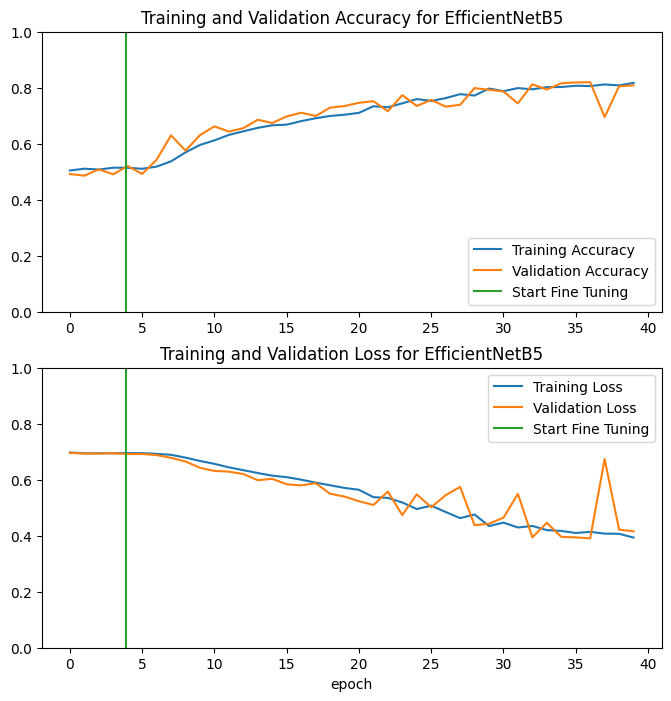

In [ ]:
# (6) plot_accuracy_and_loss
EfficientNetB7.plot_accuracy_and_loss("EfficientNetB5", 0, 1, False, False)

Training accuracy: [0.5105456709861755, 0.518256425857544, 0.5372159481048584, 0.5690569877624512, 0.5956366062164307, 0.6119653582572937, 0.6314237713813782, 0.6443053483963013, 0.6567333340644836, 0.6658048629760742, 0.6680727601051331, 0.6806368231773376, 0.6908876299858093, 0.6992334723472595, 0.7035424113273621, 0.7102553844451904, 0.7337960004806519, 0.7301220297813416, 0.7442736029624939, 0.7593323588371277, 0.7528008222579956, 0.7629156112670898, 0.77693110704422, 0.7720778584480286, 0.7970699071884155, 0.7878169417381287, 0.7986120581626892, 0.794348418712616, 0.8021045923233032, 0.8025128245353699, 0.8070485591888428, 0.8058692812919617, 0.8117204308509827, 0.8084093332290649, 0.8172540664672852]
Validation accuracy: [0.4919252395629883, 0.5429141521453857, 0.6300126910209656, 0.5753946900367737, 0.6307384967803955, 0.6619488000869751, 0.6434403657913208, 0.6555978655815125, 0.6855379939079285, 0.6741063594818115, 0.6975140571594238, 0.7107602953910828, 0.6989657282829285, 0.

<Figure size 2000x3000 with 0 Axes>

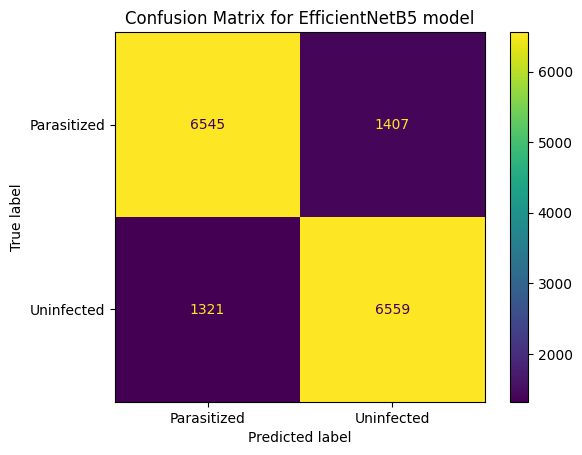

In [ ]:
# (7) Print the classification report and confusion matrix for the model on the test data set
with tf.device('/GPU:0'):
  EfficientNetB7.print_model_classification_report()

### Defining the CNN architecture

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
cnn_model = Sequential([
    # Input layer
    layers.Conv2D(filters = 128, kernel_size = (3,3), input_shape = (128, 128 , 3), activation="relu", padding="same"),
    layers.MaxPool2D(pool_size = (2,2)),

    # First hidden layer
    layers.Conv2D(filters=32, kernel_size = (3,3), activation="relu", padding="same"),
    layers.MaxPool2D(pool_size = (4,4)),

    # Second hidden layer
    layers.Conv2D(filters=(64), kernel_size=(3,3), activation="relu", padding="same"),
    layers.MaxPool2D(pool_size = (2,2)),

    layers.Conv2D(filters=(128), kernel_size=(3,3), activation="relu", padding="same"),
    layers.MaxPool2D(pool_size = (2,2)),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation = "sigmoid")
])

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        36896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)          0

### Compile the model
+ Using Adam optimizer,
+ the binay_crossentropy loss function
+ and accuracy as the metric

In [ ]:
cnn_model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics=["accuracy"]
             )

In [ ]:
history = cnn_model.fit(
    train_ds,
    epochs = 30,
    validation_data = val_ds
)

Epoch 1/30
44/44 [==============================] - 77s 2s/step - loss: 0.6663 - accuracy: 0.5910 - val_loss: 0.5739 - val_accuracy: 0.7625
Epoch 2/30
44/44 [==============================] - 76s 2s/step - loss: 0.3911 - accuracy: 0.8502 - val_loss: 0.2563 - val_accuracy: 0.9320
Epoch 3/30
44/44 [==============================] - 75s 2s/step - loss: 0.1904 - accuracy: 0.9389 - val_loss: 0.1543 - val_accuracy: 0.9557
Epoch 4/30
44/44 [==============================] - 76s 2s/step - loss: 0.1675 - accuracy: 0.9497 - val_loss: 0.1419 - val_accuracy: 0.9574
Epoch 5/30
44/44 [==============================] - 75s 2s/step - loss: 0.1660 - accuracy: 0.9507 - val_loss: 0.1400 - val_accuracy: 0.9568
Epoch 6/30
44/44 [==============================] - 76s 2s/step - loss: 0.1540 - accuracy: 0.9521 - val_loss: 0.1402 - val_accuracy: 0.9583
Epoch 7/30
44/44 [==============================] - 76s 2s/step - loss: 0.1523 - accuracy: 0.9548 - val_loss: 0.1339 - val_accuracy: 0.9603
Epoch 8/30
44/44 [==

### Plotting training loss against validation loss for the CNN

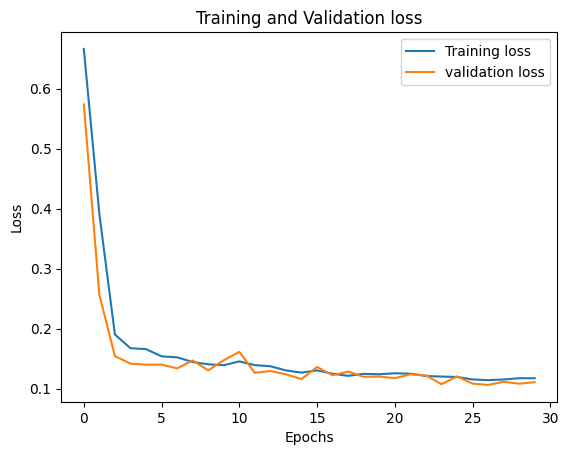

In [ ]:
# Plot training loss against validation loss

#Plots the training loss as a line with label "Training loss"
plt.plot(history.history["loss"], label="Training loss")

#Plots the validation loss as a line with label "validation loss"
plt.plot(history.history["val_loss"], label="validation loss")

#Sets the title of the plot to "Training and Validation loss"
plt.title("Training and Validation loss")

#Sets the label of the x-axis to "Epochs"
plt.xlabel("Epochs")

#Sets the label of the y-axis to "loss"
plt.ylabel("Loss")

#Shows the legend of the plot with the labels of the two lines.
plt.legend()

#Show the plot on the screen
plt.show()

### Plotting training loss against validation loss for the CNN

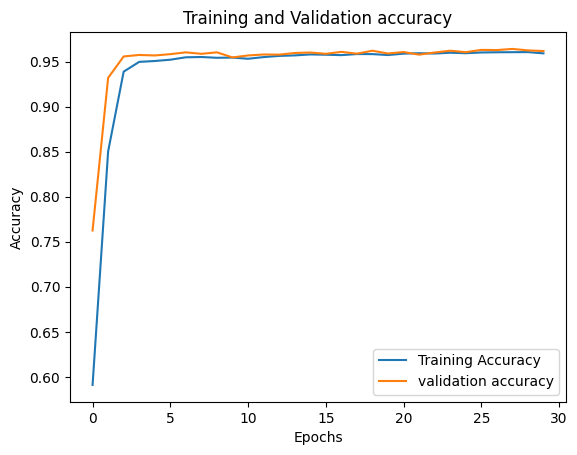

In [ ]:
# Plot training loss against validation loss

#Plots the training loss as a line with label "Training loss"
plt.plot(history.history["accuracy"], label="Training Accuracy")

#Plots the validation loss as a line with label "validation loss"
plt.plot(history.history["val_accuracy"], label="validation accuracy")

#Sets the title of the plot to "Training and Validation loss"
plt.title("Training and Validation accuracy")

#Sets the label of the x-axis to "Epochs"
plt.xlabel("Epochs")

#Sets the label of the y-axis to "loss"
plt.ylabel("Accuracy")

#Shows the legend of the plot with the labels of the two lines.
plt.legend()

#Show the plot on the screen
plt.show()

In [19]:
def use_image_generator(directory, batch_size):
    datagen = ImageDataGenerator(rescale=1.0/255.0)

    dataset = datagen.flow_from_directory(
        directory,
        target_size = image_size,
        batch_size = batch_size,
        class_mode="binary",
        shuffle = False
    )
    return dataset

In [20]:
x_train = use_image_generator(data_dir, 32)
y_train = x_train.labels

Found 27558 images belonging to 2 classes.


In [21]:
x_test = use_image_generator(test_dir, 512)
y_test = x_test.labels

Found 15832 images belonging to 2 classes.


In [22]:
x_test_for_cnn_ml = use_image_generator(test_dir, 32)
y_test_for_cnn_ml = x_test_for_cnn_ml.labels

Found 15832 images belonging to 2 classes.


In [ ]:
y_pred = cnn_model.predict(x_test)

31/31 [==============================] - 19s 613ms/step


In [ ]:
y_pred = np.round(y_pred).flatten()

In [ ]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9800    0.9362    0.9576      7952
           1     0.9384    0.9807    0.9591      7880

    accuracy                         0.9584     15832
   macro avg     0.9592    0.9585    0.9584     15832
weighted avg     0.9593    0.9584    0.9584     15832



<Figure size 2000x3000 with 0 Axes>

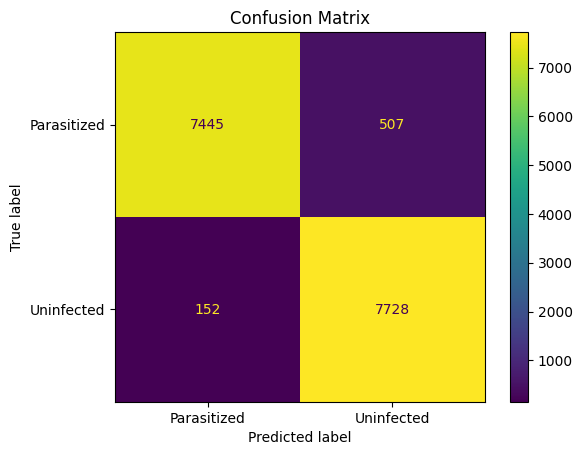

In [ ]:
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_names)
plt.title("Confusion Matrix")
plt.show()

### Preparing for the hybrid of the CNN model and the traditional machine learning models

In [53]:
tf.keras.backend.clear_session()

In [54]:
feature_extractor = Sequential([
    # Input layer
    layers.Conv2D(filters = 128, kernel_size = (3,3), input_shape = (128, 128 , 3), activation="relu", padding="same"),
    layers.MaxPool2D(pool_size = (2,2)),

    # First hidden layer
    layers.Conv2D(filters=32, kernel_size = (3,3), activation="relu", padding="same"),
    layers.MaxPool2D(pool_size = (4,4)),

    # Second hidden layer
    layers.Conv2D(filters=(64), kernel_size=(3,3), activation="relu", padding="same"),
    layers.MaxPool2D(pool_size = (2,2)),

    layers.Conv2D(filters=(128), kernel_size=(3,3), activation="relu", padding="same"),
    layers.MaxPool2D(pool_size = (2,2)),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation = "sigmoid")
])

feature_extractor.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics=["accuracy"]
             )

feature_extractor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        36896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)          0

In [55]:
extractor_history = feature_extractor.fit(
    train_ds,
    epochs = 30,
    validation_data = val_ds
)

Epoch 1/30
44/44 [==============================] - 22s 442ms/step - loss: 4.1938 - accuracy: 0.5460 - val_loss: 0.6084 - val_accuracy: 0.6712
Epoch 2/30
44/44 [==============================] - 20s 443ms/step - loss: 0.4920 - accuracy: 0.7683 - val_loss: 0.3000 - val_accuracy: 0.9067
Epoch 3/30
44/44 [==============================] - 21s 452ms/step - loss: 0.2018 - accuracy: 0.9281 - val_loss: 0.1747 - val_accuracy: 0.9394
Epoch 4/30
44/44 [==============================] - 20s 440ms/step - loss: 0.1673 - accuracy: 0.9447 - val_loss: 0.1497 - val_accuracy: 0.9503
Epoch 5/30
44/44 [==============================] - 20s 440ms/step - loss: 0.1460 - accuracy: 0.9516 - val_loss: 0.1393 - val_accuracy: 0.9539
Epoch 6/30
44/44 [==============================] - 20s 442ms/step - loss: 0.1395 - accuracy: 0.9534 - val_loss: 0.1538 - val_accuracy: 0.9488
Epoch 7/30
44/44 [==============================] - 20s 441ms/step - loss: 0.1294 - accuracy: 0.9565 - val_loss: 0.1711 - val_accuracy: 0.9505

In [56]:
feature_extractor.pop()
feature_extractor.pop()
feature_extractor.pop()
feature_extractor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        36896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)          0

In [57]:
x_train_features = feature_extractor.predict(x_train)

862/862 [==============================] - 29s 33ms/step


In [58]:
x_test_features = feature_extractor.predict(x_test_for_cnn_ml)

495/495 [==============================] - 17s 35ms/step


### Using CNN-RF

In [143]:
rf = RandomForestClassifier()

##### Using Gridsearch to find the bestg parameters for Random Forest in classifying the dataset

In [144]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train_features, y_train)

rf_best_params = grid_search.best_params_
rf_best_model = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


##### Using the best parameters to create and instance of the random forest

In [65]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 30, min_samples_split=10, min_samples_leaf = 4,  random_state = 42)

##### Fitting the Random forest classifier with the features extracted from the CNN

In [66]:
rf.fit(x_train_features, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

##### Predicting the test dataset with the CNN-RF model

In [67]:
rf_y_pred = rf.predict(x_test_features)

In [68]:
print(classification_report(y_test_for_cnn_ml, rf_y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9797    0.9671    0.9734      7952
           1     0.9672    0.9798    0.9735      7880

    accuracy                         0.9734     15832
   macro avg     0.9735    0.9734    0.9734     15832
weighted avg     0.9735    0.9734    0.9734     15832



<Figure size 2000x3000 with 0 Axes>

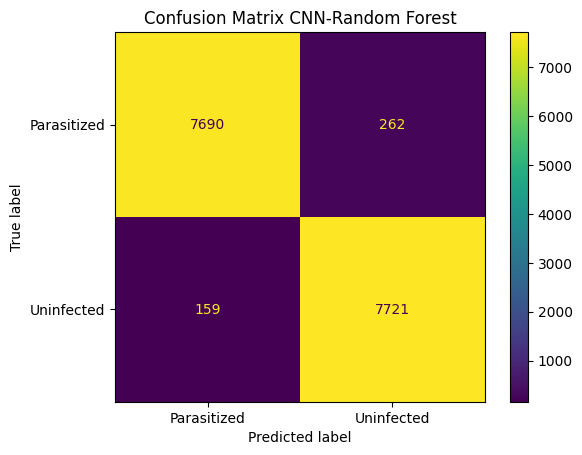

In [82]:
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test_for_cnn_ml, rf_y_pred, display_labels = class_names)
plt.title("Confusion Matrix CNN-Random Forest")
plt.show()

### Using the CNN-SVM

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto']
}

In [88]:
cnn_svm = svm.SVC(kernel="linear", C= 10, gamma = "auto")

In [89]:
cnn_svm.fit(x_train_features, y_train)

SVC(C=10, gamma='auto', kernel='linear')

In [90]:
svm_y_pred = cnn_svm.predict(x_test_features)

In [91]:
print(classification_report(y_test_for_cnn_ml, svm_y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9712    0.8734    0.9197      7952
           1     0.8840    0.9739    0.9268      7880

    accuracy                         0.9234     15832
   macro avg     0.9276    0.9236    0.9232     15832
weighted avg     0.9278    0.9234    0.9232     15832



<Figure size 2000x3000 with 0 Axes>

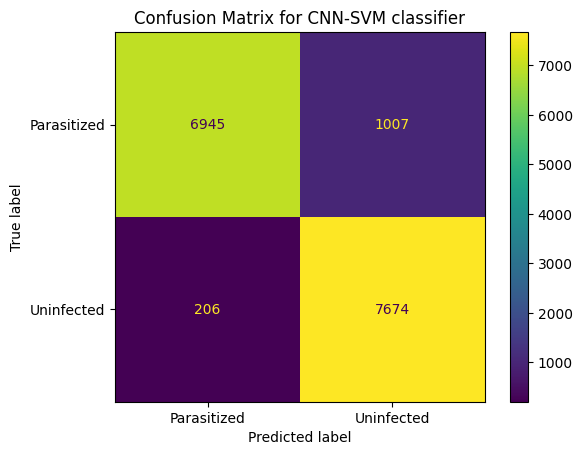

In [92]:
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test_for_cnn_ml, svm_y_pred, display_labels = class_names)
plt.title("Confusion Matrix for CNN-SVM classifier")
plt.show()